# Notebook de nettoyage du jeu de données Open Food Facts

* Le jeu de données est issu du lien suivant : https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv
* Les informations liées aux champs et aux colonnes du jeu de données sont répértoriés ici : https://static.openfoodfacts.org/data/data-fields.txt

In [1]:
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

## Chargement des données

In [2]:
fn = "../data/off_en.csv"
df0 = pd.read_csv(fn, delimiter = '\t', encoding='utf8',quoting=True)

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,8,13,27,28,29,31,47,52,55,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Traitement des erreurs
* Il y a des erreurs lors du chargement de certaines colonnes visiblement dûes au fait que ces colonnes comportent des éléments de <code>dtype</code> différent.
***

In [3]:
cat0 = df0.columns
err_index = [0,8,13,27,28,29,31,47,52,55,64]

print("Le jeu de données initial est composé de {} colonnes et {} lignes.\n".format(df0.shape[1], df0.shape[0]))

print("Il y a eu des erreurs de chargement pour les colonnes suivantes :\n")
for i in err_index:
    #types = [type(k) for k in df0[cat0[i]]]
    print("\t",cat0[i])
    #print("\t\t",set(types),"\n\n")

Le jeu de données initial est composé de 186 colonnes et 1828249 lignes.

Il y a eu des erreurs de chargement pour les colonnes suivantes :

	 code
	 abbreviated_product_name
	 packaging_text
	 emb_codes
	 emb_codes_tags
	 first_packaging_code_geo
	 cities_tags
	 additives
	 ingredients_from_palm_oil_tags
	 ingredients_that_may_be_from_palm_oil_tags
	 brand_owner


***
* Nous allons tout d'abord traiter la colonne <code>code</code>

In [4]:
types = [type(i) for i in df0['code']]
ws = np.where(np.array(types)==str)[0]
wi = np.where(np.array(types)==int)[0]
print("nombre de str : ", len(ws))
print("nombre de int : ", len(wi))
print("nombre de codes : ", df0.shape[0])
print(len(wi)+len(ws))

nombre de str :  521625
nombre de int :  1306624
nombre de codes :  1828249
1828249


In [5]:
print("{} est de type : {}".format(df0['code'][ws[100]], type(df0['code'][ws[100]])))

0000000013406 est de type : <class 'str'>


In [6]:
print("{} est de type : {}".format(df0['code'][wi[100]],  type(df0['code'][wi[100]])))

97079 est de type : <class 'int'>


In [7]:
df0['code'][0]

'0000000000017'

In [8]:
int(df0['code'][0])

17

Le format <code>int</code> ne semble pas adapté pour exprimer tous les codes barres, notamment ceux qui commencent par des <code>0</code>. Il semble préférable d'avoir des valeurs en <code>str</code>.

In [9]:
df1 = df0.astype({'code': str})
types_ = [type(i) for i in df1['code']]
print(set(types_))

{<class 'str'>}


***
## Nettoyage des données
### Sélection des produits vendus en France
* Nous allons effectuer un premier filtrage qui consiste à selectionner les produits vendus en <b>France</b> uniquement.

In [10]:
# Liste des pays présents dans le jeu de données
df1['countries_tags'].unique()

array(['en:france', 'en:spain', 'en:united-states', ...,
       'en:algeria,en:egypt,en:malaysia,en:morocco,en:saudi-arabia,en:syria,en:tunisia',
       'en:spain,en:argentina-espanol,en:armenia-pyсский,en:aruba-espanol,en:asia-pacific,en:australia-english,en:austria-deutsch,en:azerbaijan-русский,en:belarus-pyсский,en:belgium-francais,en:belgium-nederlands,en:bolivia-espanol,en:bosnia-i-hercegovina-bosnian,en:botswana-english,en:brazil-portugues,en:bulgaria-български,en:cambodia-english,en:cambodia-ភាសាខ្មែរ,en:canada-english,en:canada-francais,en:chile-espanol,en:china-中文,en:colombia-espanol,en:costa-rica-espanol,en:croatia-hrvatski,en:cyprus-ελληνικά,en:czech-republic-čeština,en:denmark-dansk,en:ecuador-espanol,en:el-salvador-espanol,en:estonia-eesti,en:europe,en:finland-suomi,en:france-francais,en:georgia-ქართული,en:germany-deutsch,en:ghana-english,en:greece-ελληνικά,en:guatemala-espanol,en:honduras-espanol,en:hong-kong-粵語,en:hungary-magyar,en:iceland-islenska,en:india-english,en:in

In [11]:
fr_index = df1.index[df1['countries_tags'].str.contains('france') == True].tolist()

In [12]:
dffr0 = df1.loc[fr_index]
print("Il ne reste plus que {} lignes à exploiter.".format(dffr0.shape[0]))
print("Nous avons retiré {} lignes".format(df1.shape[0] - dffr0.shape[0]))

Il ne reste plus que 811463 lignes à exploiter.
Nous avons retiré 1016786 lignes


***
### Observation sur les données manquantes
* Nous allons à présent faire une exploration de surface pour estimer la consistance des données et observer la part de données manquantes.

In [13]:
nansr = np.array(dffr0.isna().sum(axis=1).tolist())      # nombre de NaN par ligne
nansc = np.array(dffr0.isna().sum(axis=0).tolist())      # nombre de NaN par colonne

In [14]:
print(max(nansr), len(nansr))
print(max(nansc), len(nansc))
binr = np.unique(nansr)
binc = np.unique(nansc)

173 811463
811463 186


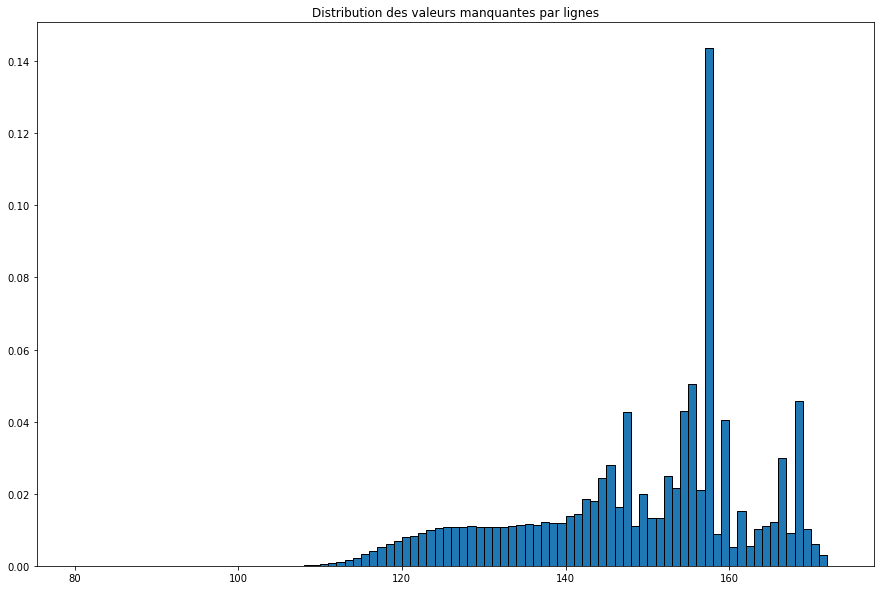

In [15]:
fig0 = plt.figure(figsize=(15,10))
plt.title("Distribution des valeurs manquantes par lignes")
_ = plt.hist(nansr,bins=binr,density=True, edgecolor='black',width=1)

* Sachant qu'il y a 186 colonnes, on observe qu'il manque en général que sur chaque ligne en général plus de la moitié des données.

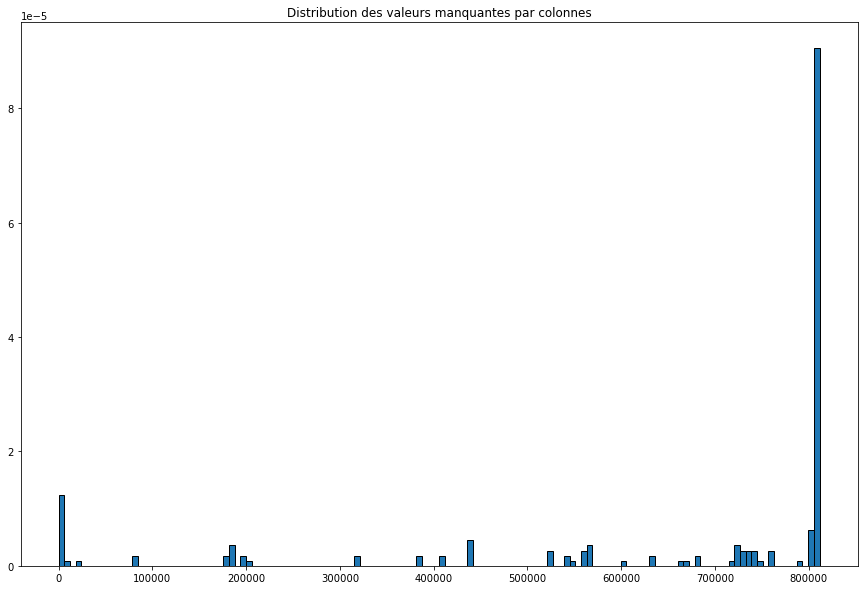

In [16]:
fig1 = plt.figure(figsize=(15,10))
plt.title("Distribution des valeurs manquantes par colonnes")
_ = plt.hist(nansc,bins=len(binc), density=True, edgecolor='black')

On observe que certaines colonnes sont presque entièrement vides
***

### Elimination des produits sans nom

In [17]:
print(dffr0['product_name'].hasnans)

True


* Nous allons effectué un filtrage supplémentaire qui va permettre de conserver uniquement les produits qu'on peut identifier par leur nom.

In [18]:
print("Il manque le nom de {} produits.".format(dffr0['product_name'].isnull().sum()))

Il manque le nom de 22876 produits.


In [19]:
dffr0['product_name'].isna()

0          False
1          False
4          False
5          False
6          False
           ...  
1828238    False
1828241    False
1828245    False
1828247    False
1828248    False
Name: product_name, Length: 811463, dtype: bool

In [20]:
no_pn_index = dffr0['product_name'].index[dffr0['product_name'].isna() == True] # index des produits sans noms
print(no_pn_index)

Int64Index([     17,      74,      83,     172,     240,     326,     339,
                346,     356,     380,
            ...
            1827995, 1828013, 1828070, 1828077, 1828086, 1828087, 1828111,
            1828148, 1828149, 1828150],
           dtype='int64', length=22876)


In [21]:
dffr0['product_name'].loc[no_pn_index]

17         NaN
74         NaN
83         NaN
172        NaN
240        NaN
          ... 
1828087    NaN
1828111    NaN
1828148    NaN
1828149    NaN
1828150    NaN
Name: product_name, Length: 22876, dtype: object

In [22]:
tmp_index = dffr0['product_name'].index[dffr0['product_name'].isna() == False] # On ignore les produits sans noms
dffr1 = dffr0.loc[tmp_index]
print("Il ne reste plus que {} lignes à exploiter, {} lignes ont été effacées.".format(dffr1.shape[0], dffr0.shape[0]- dffr1.shape[0]))

Il ne reste plus que 788587 lignes à exploiter, 22876 lignes ont été effacées.


In [23]:
print("Pourcentage de données manquantes par colonne :\n")
notemptycols = []
cat0 = dffr1.columns
for i in range(len(cat0)):
    tmp = np.round(100*dffr1[cat0[i]].isna().sum()/dffr1.shape[0],5)
    print("\t{}\t\t{}".format(tmp,cat0[i]))
    if tmp < 100:
        notemptycols.append(i)

print("\nnombre de colonnes complétement vides : {}/{}".format(dffr1.shape[1]-len(notemptycols),dffr1.shape[1]))

Pourcentage de données manquantes par colonne :

	0.0		code
	0.0		url
	0.00013		creator
	0.0		created_t
	0.0		created_datetime
	0.0		last_modified_t
	0.0		last_modified_datetime
	0.0		product_name
	99.23915		abbreviated_product_name
	90.05056		generic_name
	66.81964		quantity
	77.56075		packaging
	77.56189		packaging_tags
	99.6287		packaging_text
	46.3874		brands
	46.39171		brands_tags
	52.94622		categories
	52.94647		categories_tags
	52.94647		categories_en
	93.7478		origins
	93.75605		origins_tags
	93.75605		origins_en
	91.00239		manufacturing_places
	91.00695		manufacturing_places_tags
	68.51723		labels
	68.51432		labels_tags
	68.51432		labels_en
	88.9089		emb_codes
	88.91105		emb_codes_tags
	91.30419		first_packaging_code_geo
	100.0		cities
	90.64808		cities_tags
	87.89531		purchase_places
	81.25445		stores
	0.0		countries
	0.0		countries_tags
	0.0		countries_en
	68.96195		ingredients_text
	88.72693		allergens
	100.0		allergens_en
	92.13162		traces
	90.07199		traces_tags
	90.07199	

***
### Elimination des doublons et colonnes inutiles
* Nous allons trier les colonnes de manière à supprimer les doublons et les un premier tri sur les informations non pertinentes.

In [24]:
useless_cats = ["url","creator", "created_datetime", "last_modified_datetime",
               "abbreviated_product_name", "generic_name", "packaging", "packaging_text", "brands",
                "categories", "categories_en", "origins", "origins_en", "manufacturing_places",
                "labels", "labels","labels_en", "emb_codes", "cities", "cities_tags", 
                "purchase_places", "stores", "countries", "countries_en", "allergens_en", "traces", "traces_en",
                "states", "states_en", "brand_owner", "image_ingredients_url", "image_ingredients_small_url", "additives", 
                "additives_en", "ingredients_from_palm_oil", "ingredients_that_may_be_from_palm_oil", "states", "states_en",
                "main_category_en", "image_url", "image_small_url", "image_nutrition_url", "image_nutrition_small_url", 
                "states_tags"
               ]
dffr1.drop( useless_cats,inplace=True, axis=1)

In [25]:
print("Pourcentage de données manquantes par colonne :\n")
notemptycols = []
cat1 = dffr1.columns
for i in range(len(cat1)):
    tmp = np.round(100*dffr1[cat1[i]].isna().sum()/dffr1.shape[0],10)
    print("\t{}\t\t{}".format(tmp,cat1[i]))
    if tmp < 100:
        notemptycols.append(i)

print("\nnombre de colonnes complétement vides : {}/{}".format(dffr1.shape[1]-len(notemptycols),dffr1.shape[1]))
print("\nnombre de lignes : ",dffr1.shape[0])

Pourcentage de données manquantes par colonne :

	0.0		code
	0.0		created_t
	0.0		last_modified_t
	0.0		product_name
	66.8196406991		quantity
	77.5618923467		packaging_tags
	46.3917107434		brands_tags
	52.9464726149		categories_tags
	93.7560472085		origins_tags
	91.0069529424		manufacturing_places_tags
	68.5143173803		labels_tags
	88.9110522999		emb_codes_tags
	91.3041934498		first_packaging_code_geo
	0.0		countries_tags
	68.9619534687		ingredients_text
	88.7269255009		allergens
	90.0719895205		traces_tags
	89.1400695167		serving_size
	89.7884443948		serving_quantity
	100.0		no_nutriments
	68.9618266596		additives_n
	83.5843096577		additives_tags
	68.9618266596		ingredients_from_palm_oil_n
	98.5028918813		ingredients_from_palm_oil_tags
	68.9618266596		ingredients_that_may_be_from_palm_oil_n
	97.1798926434		ingredients_that_may_be_from_palm_oil_tags
	63.5499951179		nutriscore_score
	63.5499951179		nutriscore_grade
	73.8820193587		nova_group
	1.4390295554		pnns_groups_1
	0.0		pnns_groups

In [26]:
dffr2 = dffr1.iloc[:,notemptycols]

***
* Il reste essentiellement des colonnes descriptives et quantitatives.

In [27]:
print("Colonnes restantes :\n")
#for c in dffr2.columns:
print( [c for c in dffr2.columns])

Colonnes restantes :

['code', 'created_t', 'last_modified_t', 'product_name', 'quantity', 'packaging_tags', 'brands_tags', 'categories_tags', 'origins_tags', 'manufacturing_places_tags', 'labels_tags', 'emb_codes_tags', 'first_packaging_code_geo', 'countries_tags', 'ingredients_text', 'allergens', 'traces_tags', 'serving_size', 'serving_quantity', 'additives_n', 'additives_tags', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_tags', 'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'ecoscore_score_fr', 'ecoscore_grade_fr', 'main_category', 'energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-acid_100g', '-b

### Résolution des problèmes d'encodage des noms de produits

In [28]:
dffr2['product_name'].unique()

array(['Vitória crackers', 'Cacao', ' moutarde au moût de raisin ', ...,
       'Minis beignets', 'Light & Free SKYR A BOIRE', 'Signal Toothpaste'],
      dtype=object)

* Certains noms sont mal encodés ou commencent/finissent par des espaces, corrigeons cela

In [29]:
indquotes = dffr2['product_name'].index[dffr2['product_name'].str.contains('quot') == True]
for i in indquotes[:5] :
    print(dffr2['product_name'][i])
    
dffr3 = dffr2.replace({"&quot;":''},regex=True)

for i in indquotes[:5] :
    print(dffr3['product_name'][i])

&quot;Baguette Lyonnais&quot;
Baguette Lyonnais &quot;Petit prix&quot;
Galettes Bretonnes 300gr - Biscuiterie &quot;le phare&quot;
Baguette Gruyère &quot;Petit Prix&quot;
Chouquettes Intermarché &quot;moche&quot;
Baguette Lyonnais
Baguette Lyonnais Petit prix
Galettes Bretonnes 300gr - Biscuiterie le phare
Baguette Gruyère Petit Prix
Chouquettes Intermarché moche


In [30]:
'   abc   '.rstrip()

'   abc'

In [31]:
dffr3['product_name'].str.rstrip()

0                     Vitória crackers
1                                Cacao
4           moutarde au moût de raisin
5                              Sfiudwx
6                Sauce Sweety chili 0%
                      ...             
1828238                 Minis beignets
1828241          Steak haché pur boeuf
1828245        Thé noir BIO Darjeeling
1828247      Light & Free SKYR A BOIRE
1828248              Signal Toothpaste
Name: product_name, Length: 788587, dtype: object

In [32]:
indendspace= dffr3['product_name'].index[dffr3['product_name'].str.endswith(' ') == True]
indstartspace= dffr3['product_name'].index[dffr3['product_name'].str.startswith(' ') == True]
dffr3['product_name'].loc[indendspace] = dffr3['product_name'].loc[indendspace].str.rstrip()
dffr3['product_name'].loc[indstartspace] = dffr3['product_name'].loc[indstartspace].str.lstrip()

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [33]:
dffr3['product_name'].unique()

array(['Vitória crackers', 'Cacao', 'moutarde au moût de raisin', ...,
       'Minis beignets', 'Light & Free SKYR A BOIRE', 'Signal Toothpaste'],
      dtype=object)

In [34]:
boolean = dffr3['product_name'].duplicated().any()
nodup = 'non'
if boolean == True:
    nodup = 'oui'
print("Y a-t-il des doublons dans la colonne des noms de produits : ",nodup)

Y a-t-il des doublons dans la colonne des noms de produits :  oui


In [35]:
dffr3['product_name'].drop_duplicates()

0                      Vitória crackers
1                                 Cacao
4            moutarde au moût de raisin
5                               Sfiudwx
6                 Sauce Sweety chili 0%
                       ...             
1828225         Cailloux Coeur Chocolat
1828232    Pastilles à l'eau de lourdes
1828238                  Minis beignets
1828247       Light & Free SKYR A BOIRE
1828248               Signal Toothpaste
Name: product_name, Length: 536208, dtype: object

* On retire les doublons en conservant la ligne la plus récemment modifiée

In [36]:
modifiedind = dffr3.sort_values('last_modified_t').drop_duplicates('product_name', keep='last').index

In [37]:
dffr4 = dffr3.loc[modifiedind,:]

In [38]:
print('Nous avons retiré {} lignes et {} colonnes, il en reste respectivement {} et {}.'.format(dffr3.shape[0]-dffr4.shape[0], dffr3.shape[1]-dffr4.shape[1], dffr4.shape[0], dffr4.shape[1]))

Nous avons retiré 252379 lignes et 0 colonnes, il en reste respectivement 536208 et 141.


In [39]:
for i in range(len(dffr4.columns)):
    print(i,"\t", dffr4.columns[i])
    
quant_cats = [c for c in dffr4.columns if '100g' in c] # Colonnes de données quantitatives
print(len(quant_cats))

0 	 code
1 	 created_t
2 	 last_modified_t
3 	 product_name
4 	 quantity
5 	 packaging_tags
6 	 brands_tags
7 	 categories_tags
8 	 origins_tags
9 	 manufacturing_places_tags
10 	 labels_tags
11 	 emb_codes_tags
12 	 first_packaging_code_geo
13 	 countries_tags
14 	 ingredients_text
15 	 allergens
16 	 traces_tags
17 	 serving_size
18 	 serving_quantity
19 	 additives_n
20 	 additives_tags
21 	 ingredients_from_palm_oil_n
22 	 ingredients_from_palm_oil_tags
23 	 ingredients_that_may_be_from_palm_oil_n
24 	 ingredients_that_may_be_from_palm_oil_tags
25 	 nutriscore_score
26 	 nutriscore_grade
27 	 nova_group
28 	 pnns_groups_1
29 	 pnns_groups_2
30 	 ecoscore_score_fr
31 	 ecoscore_grade_fr
32 	 main_category
33 	 energy-kj_100g
34 	 energy-kcal_100g
35 	 energy_100g
36 	 energy-from-fat_100g
37 	 fat_100g
38 	 saturated-fat_100g
39 	 -butyric-acid_100g
40 	 -caproic-acid_100g
41 	 -caprylic-acid_100g
42 	 -capric-acid_100g
43 	 -lauric-acid_100g
44 	 -myristic-acid_100g
45 	 -palmitic-

### Nettoyage des données quantitatives

In [40]:
indtmp = np.array(dffr4[quant_cats].isna().sum(axis=1).tolist())

if len(quant_cats) == max(indtmp):
    wm4 = np.where(indtmp == len(quant_cats))[0]
    print("Il y a {} lignes qui n'ont aucune donnée quantitative, il faut les supprimer".format(len(wm4)))
    
else:
    print("Toutes les lignes contiennent au moins une donnée quantitative")

dffr4 = dffr4.drop(dffr4.index[wm4])
print("Il reste {} lignes et {} colonnes à exploiter".format(dffr4.shape[0],dffr4.shape[1]))

Il y a 90430 lignes qui n'ont aucune donnée quantitative, il faut les supprimer
Il reste 445778 lignes et 141 colonnes à exploiter


***
* Il est raisonable de penser que pour les données quantitatives l'abscence de données pour un certain produit dans une colonne quantitative revient à dire que l'ingrédient de la colonne considérée n'est pas présent dans le produit en question. Nous pouvons remplacer les valeurs <code>Nan</code> par <code>0</code>

In [41]:
for qc in quant_cats:
    print(qc)

energy-kj_100g
energy-kcal_100g
energy_100g
energy-from-fat_100g
fat_100g
saturated-fat_100g
-butyric-acid_100g
-caproic-acid_100g
-caprylic-acid_100g
-capric-acid_100g
-lauric-acid_100g
-myristic-acid_100g
-palmitic-acid_100g
-stearic-acid_100g
-arachidic-acid_100g
-behenic-acid_100g
-lignoceric-acid_100g
-cerotic-acid_100g
-montanic-acid_100g
-melissic-acid_100g
monounsaturated-fat_100g
polyunsaturated-fat_100g
omega-3-fat_100g
-alpha-linolenic-acid_100g
-eicosapentaenoic-acid_100g
-docosahexaenoic-acid_100g
omega-6-fat_100g
-linoleic-acid_100g
-arachidonic-acid_100g
-gamma-linolenic-acid_100g
omega-9-fat_100g
-oleic-acid_100g
-gondoic-acid_100g
-mead-acid_100g
-erucic-acid_100g
-nervonic-acid_100g
trans-fat_100g
cholesterol_100g
carbohydrates_100g
sugars_100g
-sucrose_100g
-glucose_100g
-fructose_100g
-lactose_100g
-maltose_100g
-maltodextrins_100g
starch_100g
polyols_100g
fiber_100g
-soluble-fiber_100g
-insoluble-fiber_100g
proteins_100g
casein_100g
serum-proteins_100g
nucleotides_

In [42]:
dffr4[quant_cats] = dffr4[quant_cats].fillna(0)

In [43]:
print("Pourcentage de données manquantes par colonne :\n")
notemptycols = []
for i in range(len(dffr4.columns)):
    tmp = np.round(100*dffr4[dffr4.columns[i]].isna().sum()/dffr4.shape[0],5)
    print("\t{}\t\t{}".format(tmp,dffr4.columns[i]))
    if tmp < 100:
        notemptycols.append(i)

print("\nnombre de colonnes complétement vides : {}/{}".format(dffr4.shape[1]-len(notemptycols),dffr4.shape[1]))

Pourcentage de données manquantes par colonne :

	0.0		code
	0.0		created_t
	0.0		last_modified_t
	0.0		product_name
	64.19249		quantity
	75.15512		packaging_tags
	40.9926		brands_tags
	54.28487		categories_tags
	93.61274		origins_tags
	89.3586		manufacturing_places_tags
	64.50946		labels_tags
	88.44335		emb_codes_tags
	91.10297		first_packaging_code_geo
	0.0		countries_tags
	62.49792		ingredients_text
	85.26778		allergens
	86.9776		traces_tags
	85.78171		serving_size
	86.43405		serving_quantity
	62.49792		additives_n
	78.92987		additives_tags
	62.49792		ingredients_from_palm_oil_n
	97.93283		ingredients_from_palm_oil_tags
	62.49792		ingredients_that_may_be_from_palm_oil_n
	96.25531		ingredients_that_may_be_from_palm_oil_tags
	59.2223		nutriscore_score
	59.2223		nutriscore_grade
	68.31786		nova_group
	1.03392		pnns_groups_1
	0.0		pnns_groups_2
	69.24119		ecoscore_score_fr
	69.24119		ecoscore_grade_fr
	54.28487		main_category
	0.0		energy-kj_100g
	0.0		energy-kcal_100g
	0.0		energy_100g

***
## Sélection des colonnes pertinentes pour la recommandation de produits ne favorisant pas l'hypertension


* Dans le cadre de notre application, nous voulons recommander des produits contenant le moins d'ingrédients favorisant l'augmentation de l'hypertension artérielle, en s'appuyant sur la documentation suivante nous avons établi qu'il est préférable d'éviter les aliments suivants : 

    * Le sel que l'on retrouve essentiellement dans :
            - Bouillons cubes
            - Mélanges d'épices
            - Moutarde
            - Fromage (se limiter à 1 portion par jour)
            - Pain classique
            - Charcuteries
            - Aliments fumés
            - Conserves de légumes et de poissons
            - Sauces industrielles
            - Biscuits salés industriels (chips par exemple)
    * Graisses saturées et trans que l'on retrouve essentiellement dans :
            - Huile de palme
            - Margarines hydrogénées
            - Produits industriels
            - Plats préparés
            - Beurre, crème entière
            - Fromage
            - Charcuteries
            - Viandes grasses
            - Produits frits et panés
            - Sauces industrielles : mayonnaise, béchamel, etc.
            - Viennoiseries, pâtisseries et biscuits sucrés ou salés
            - Fast-food, pizza, etc.
    * Boissons sucrées

### Sources

* http://www.emro.who.int/fr/world-health-days/journee-mondiale-de-la-sante-2013/nutrition-hypertension-factsheet-whd-2013.html
* https://fr.wikipedia.org/wiki/Hypertension_art%C3%A9rielle#Alimentation
* https://en.wikipedia.org/wiki/List_of_saturated_fatty_acids
* https://en.wikipedia.org/wiki/List_of_unsaturated_fatty_acids

***
Parmis les ingrédients listés dans le jeu de données, nous conserveront donc les gras saturés, les gras trans, le sel, le sodium, les différents sucres.

### Sélection des produits par le nutriscore
***
Nous conservons les données pour les produits pour lesquels la variable <code>nutriscore_grade</code> est fournie.

In [44]:
ind_nutr = dffr4.index[dffr4['nutriscore_grade'].notnull() == True].tolist()
dffr5 = dffr4.loc[ind_nutr]
palette = {'a':'darkgreen', 'b':'limegreen', 'c':'gold', 'd':'darkorange', 'e':'orangered'}

In [45]:
print('Nous avons retiré {} lignes et {} colonnes, il en reste respectivement {} et {}.'.format(dffr4.shape[0]-dffr5.shape[0], dffr4.shape[1]-dffr5.shape[1], dffr4.shape[0], dffr5.shape[1]))

Nous avons retiré 264000 lignes et 0 colonnes, il en reste respectivement 445778 et 141.


### Sélection des colonnes contenant suffisamment de données

In [46]:
X = (dffr5['fat_100g'] > 0).astype(float).unique()
Y = (dffr5[quant_cats] > 0).sum(axis=0)
Z = (dffr5[quant_cats] <= 0).sum(axis=0)

In [47]:
Y = 100*Y/dffr5.shape[0]
Z = 100*Z/dffr5.shape[0]

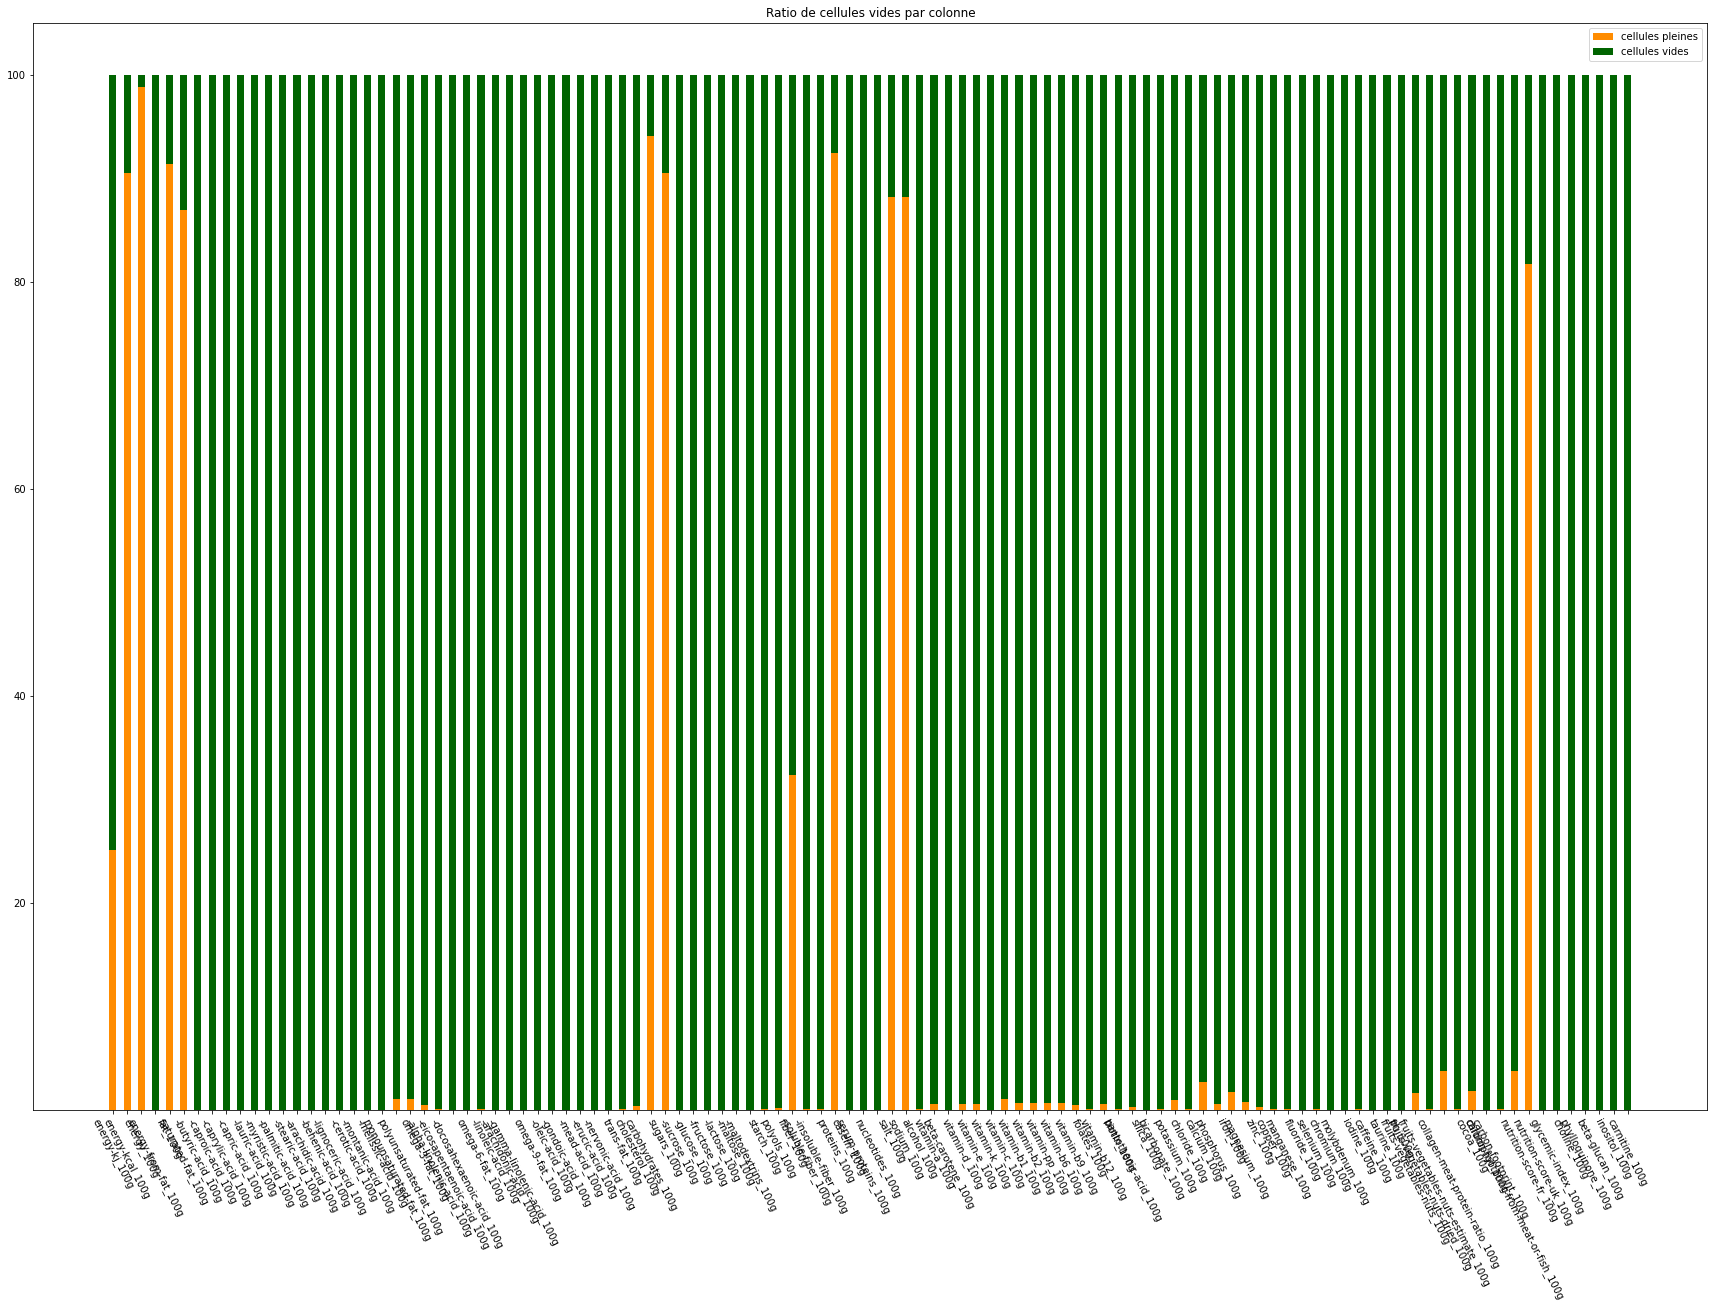

In [48]:
figg = plt.figure(figsize=(30,20))
plt.title('Ratio de cellules vides par colonne')
plt.bar(quant_cats,Y,label='cellules pleines',width=0.5, color='darkorange')
plt.bar(quant_cats,Z,bottom=Y,label='cellules vides',width=0.5, color='darkgreen')
plt.xticks(rotation=-62.5)
plt.legend()

* Il apparait que certaines colonnes ne contiennent pas assez d'information, nous allons conserver pour l'instant celles qui possèdent au moins 20% d'information. Cela ce sont en général les colonnes concernant ingrédients très spécifiques ces informations peuvent être retrouvées dans catégories plus globales. C'est le cas par exemple pour les acides gras saturés et non saturés
        
    * https://en.wikipedia.org/wiki/List_of_saturated_fatty_acids
    * https://en.wikipedia.org/wiki/List_of_unsaturated_fatty_acids

In [49]:
tokeep = []
for i in range(len(quant_cats)):
    if Z[i] <= 80:
        tokeep.append(i)
quant_cats = np.array(quant_cats)[tokeep]

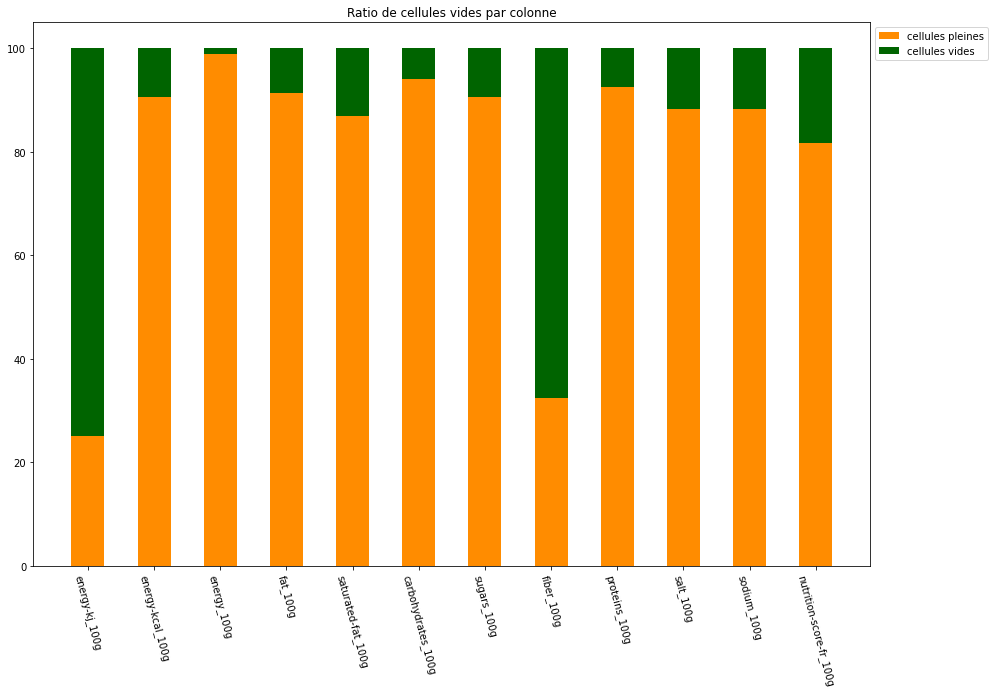

In [50]:
X = (dffr5['fat_100g'] > 0).astype(float).unique()
Y = (dffr5[quant_cats] > 0).sum(axis=0)
Z = (dffr5[quant_cats] <= 0).sum(axis=0)
Y = 100*Y/dffr5.shape[0]
Z = 100*Z/dffr5.shape[0]
plt.figure(figsize=(15,10))
plt.title('Ratio de cellules vides par colonne')
plt.bar(quant_cats,Y,label='cellules pleines',width=0.5, color='darkorange')
plt.bar(quant_cats,Z,bottom=Y,label='cellules vides',width=0.5, color='darkgreen')
plt.xticks(rotation=-75)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

* Plusieurs doublons concernent la colonne <code>energy</code>, nous allons retirer celles qui contiennent moins de données.
* Les fibres et les protéines ne sont pas des ingrédients qui impactent de manière négative la santé de personnes souffrant d'hypertension, nous supprimons aussi cette colonne.

In [51]:
quant_cats = quant_cats[2:]

In [52]:
quant_cats = [c for c in quant_cats]

In [53]:
fiberid = np.where(np.array(quant_cats) == 'fiber_100g')[0][0]
quant_cats.pop(fiberid)
print(quant_cats)
protid = np.where(np.array(quant_cats) == 'proteins_100g')[0][0]
quant_cats.pop(protid)
print(quant_cats)

['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g']
['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g']


In [54]:
quant_cats.append('nutriscore_grade')
quant_cats = np.array(quant_cats)

In [55]:
print("Il nous reste {} colonnes et {} lignes".format(len(quant_cats),dffr5.shape[0]))

Il nous reste 9 colonnes et 181778 lignes


# Nettoyage des valeurs aberrantes

## Observations sur les plages de valeurs

In [56]:
for c in quant_cats[:-3]:
    print(c)
    print("\t min value : ",dffr5[c].min())
    print("\t max value : ",dffr5[c].max())
    print("\t variance : ", dffr5[c].var())
    print("\t mean : ", dffr5[c].mean())
    print("\t median : ", dffr5[c].median())
    print()

energy_100g
	 min value :  0.0
	 max value :  12200000.0
	 variance :  819313609.307424
	 mean :  1230.824949518619
	 median :  1067.0

fat_100g
	 min value :  0.0
	 max value :  91200.0
	 variance :  46053.90371559958
	 mean :  15.141205531148119
	 median :  8.7

saturated-fat_100g
	 min value :  0.0
	 max value :  21900.0
	 variance :  2707.367348924223
	 mean :  5.813003976709928
	 median :  2.2000000476837

carbohydrates_100g
	 min value :  0.0
	 max value :  117000.0
	 variance :  75992.38235588078
	 mean :  27.513831619179005
	 median :  14.5

sugars_100g
	 min value :  0.0
	 max value :  6880.0
	 variance :  609.2496115624712
	 mean :  13.414664432981493
	 median :  3.9

salt_100g
	 min value :  0.0
	 max value :  25000.0
	 variance :  3647.69058213011
	 mean :  1.1936769428729683
	 median :  0.53



* Il apparait clairement que certaines colonnes contiennent des valeurs qui ne respectent pas la nomenclature du jeu de données, notament pour les ingrédients dont les valeurs ne se situent pas dans l'intervalle <code>[0,100]</code>. Il va falloir observer la répartition des valeurs pour chaque colonne pour établir dans quelle proportion certaines colonnes contiennent des valeurs aberrantes. Cela est peut être dû à une erreur de saisie.

***
Si on se réfère à la nomenclature sur un échantillon de 100g il n'est pas possible d'avoir plus de 100g d'un même ingrédient

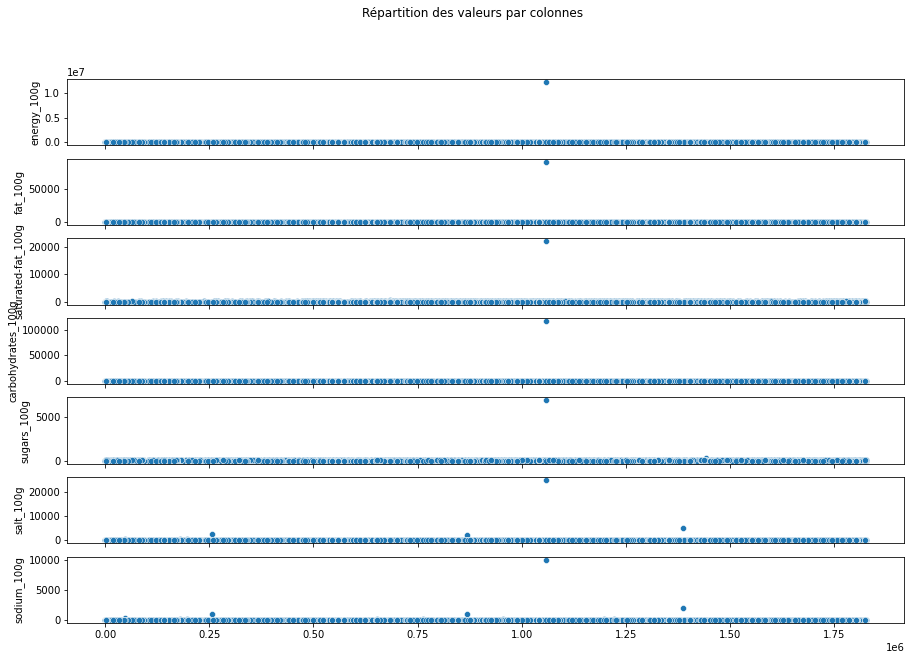

In [57]:
#%matplotlib qt   <-- pour une sortie externe permettant de zoomer
fig, ax = plt.subplots(len(quant_cats[:-2]),1, figsize=(15,10), sharex=True)
plt.suptitle("Répartition des valeurs par colonnes")
for i in range(len(quant_cats[:-2])):
    sns.scatterplot(data=dffr5[quant_cats[i]], ax=ax[i])

In [58]:
print("le max se situe à la ligne : ")
for c in quant_cats[:-3]:
    print(c, " - \t", dffr5[c].idxmax())

le max se situe à la ligne : 
energy_100g  - 	 1057754
fat_100g  - 	 1057754
saturated-fat_100g  - 	 1057754
carbohydrates_100g  - 	 1057754
sugars_100g  - 	 1057754
salt_100g  - 	 1057754


* On remarque sur le graphique précédent la présence de plusieurs valeurs qui sont trés éloignées du reste des valeurs, et nous pouvons aussi remarquer que cela correspond à la même ligne. Il convient de supprimer cette ligne.

In [59]:
dffr6 = dffr5.drop(dffr5[quant_cats[0]].idxmax())

In [60]:
print(dffr5.shape)
print(dffr6.shape)

(181778, 141)
(181777, 141)


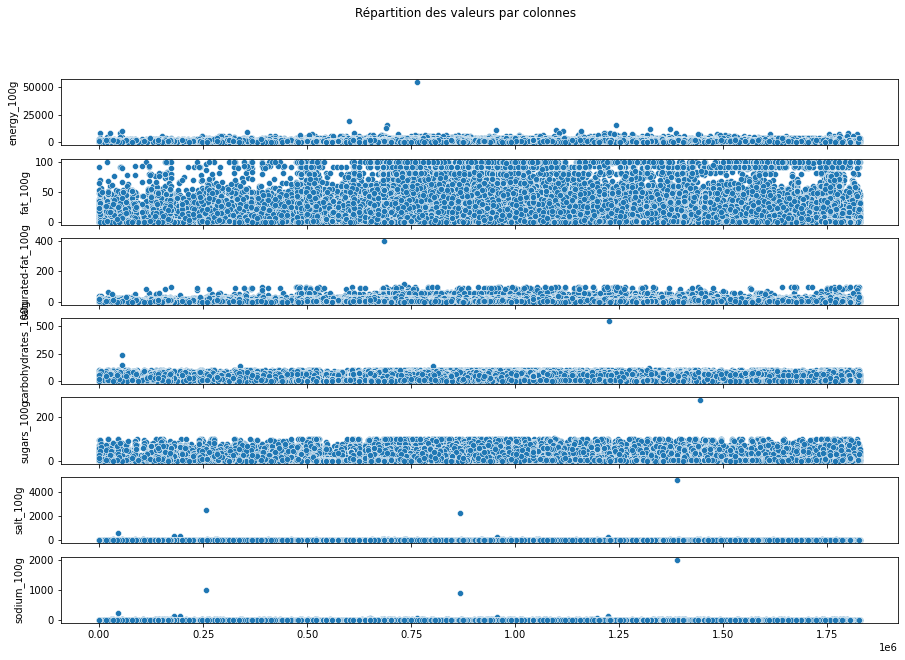

In [61]:
#%matplotlib qt   <-- pour une sortie externe permettant de zoomer
fig, ax = plt.subplots(len(quant_cats[:-2]),1, figsize=(15,10), sharex=True)
plt.suptitle("Répartition des valeurs par colonnes")
for i in range(len(quant_cats[:-2])):
    sns.scatterplot(data=dffr6[quant_cats[i]], ax=ax[i])

* Nous pouvons à présent faire un nettoyage plus ciblé, il y a toujours quelques valeurs aberrantes mais elles ne concernent pas toutes la même ligne.

In [62]:
for c in quant_cats[1:-2]:
    dffr6.loc[dffr6[c] > 100, c] = 100

In [63]:
for c in quant_cats[:-2]:
    print(c)
    print("\t min value : ",dffr6[c].min())
    print("\t max value : ",dffr6[c].max())
    print("\t variance : ", dffr6[c].var())
    print("\t mean : ", dffr6[c].mean())
    print("\t median : ", dffr6[c].median())
    print()

energy_100g
	 min value :  0.0
	 max value :  54700.0
	 variance :  668855.8041775973
	 mean :  1163.716518996328
	 median :  1067.0

fat_100g
	 min value :  0.0
	 max value :  100.0
	 variance :  312.56184122967164
	 mean :  14.639575188505932
	 median :  8.7

saturated-fat_100g
	 min value :  0.0
	 max value :  100.0
	 variance :  69.47174539354602
	 mean :  5.690798268638922
	 median :  2.2000000476837

carbohydrates_100g
	 min value :  0.0
	 max value :  100.0
	 variance :  718.983771883976
	 mean :  26.866252518586624
	 median :  14.5

sugars_100g
	 min value :  0.0
	 max value :  100.0
	 variance :  349.52772209188595
	 mean :  13.375907685232509
	 median :  3.9

salt_100g
	 min value :  0.0
	 max value :  100.0
	 variance :  6.564847272398449
	 mean :  0.9967664078599738
	 median :  0.53

sodium_100g
	 min value :  0.0
	 max value :  100.0
	 variance :  1.4447513589901142
	 mean :  0.40176292932298374
	 median :  0.212



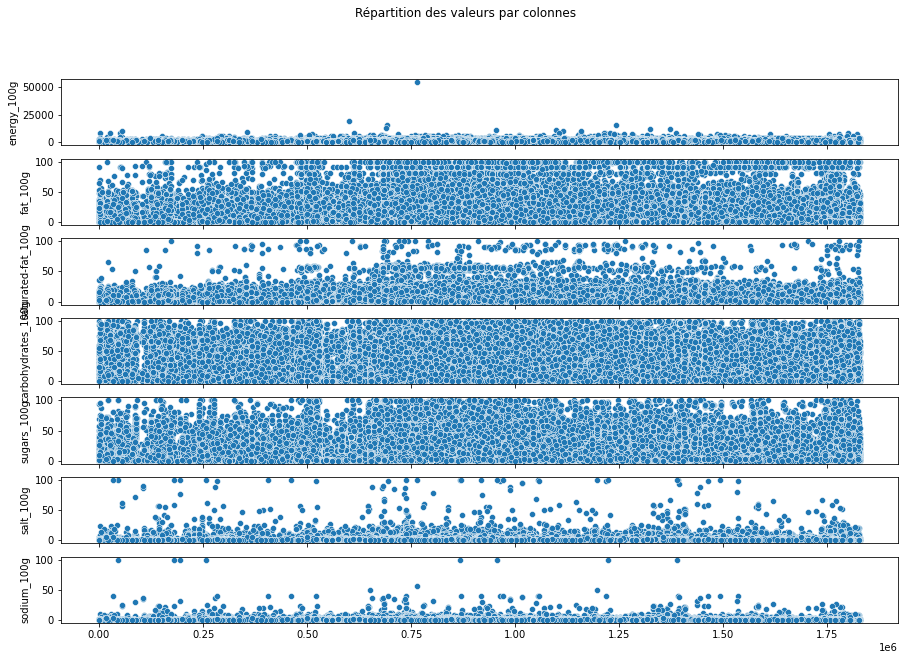

In [64]:
#%matplotlib qt   <-- pour une sortie externe permettant de zoomer
fig, ax = plt.subplots(len(quant_cats[:-2]),1, figsize=(15,10), sharex=True)
plt.suptitle("Répartition des valeurs par colonnes")
for i in range(len(quant_cats[:-2])):
    sns.scatterplot(data=dffr6[quant_cats[i]], ax=ax[i])

In [65]:
for c in quant_cats[:-3]:
    print(c)
    print("\t min value : ",dffr6[c].min())
    print("\t max value : ",dffr6[c].max())
    print("\t variance : ", dffr6[c].var())
    print("\t mean : ", dffr6[c].mean())
    print("\t median : ", dffr6[c].median())
    print()

energy_100g
	 min value :  0.0
	 max value :  54700.0
	 variance :  668855.8041775973
	 mean :  1163.716518996328
	 median :  1067.0

fat_100g
	 min value :  0.0
	 max value :  100.0
	 variance :  312.56184122967164
	 mean :  14.639575188505932
	 median :  8.7

saturated-fat_100g
	 min value :  0.0
	 max value :  100.0
	 variance :  69.47174539354602
	 mean :  5.690798268638922
	 median :  2.2000000476837

carbohydrates_100g
	 min value :  0.0
	 max value :  100.0
	 variance :  718.983771883976
	 mean :  26.866252518586624
	 median :  14.5

sugars_100g
	 min value :  0.0
	 max value :  100.0
	 variance :  349.52772209188595
	 mean :  13.375907685232509
	 median :  3.9

salt_100g
	 min value :  0.0
	 max value :  100.0
	 variance :  6.564847272398449
	 mean :  0.9967664078599738
	 median :  0.53



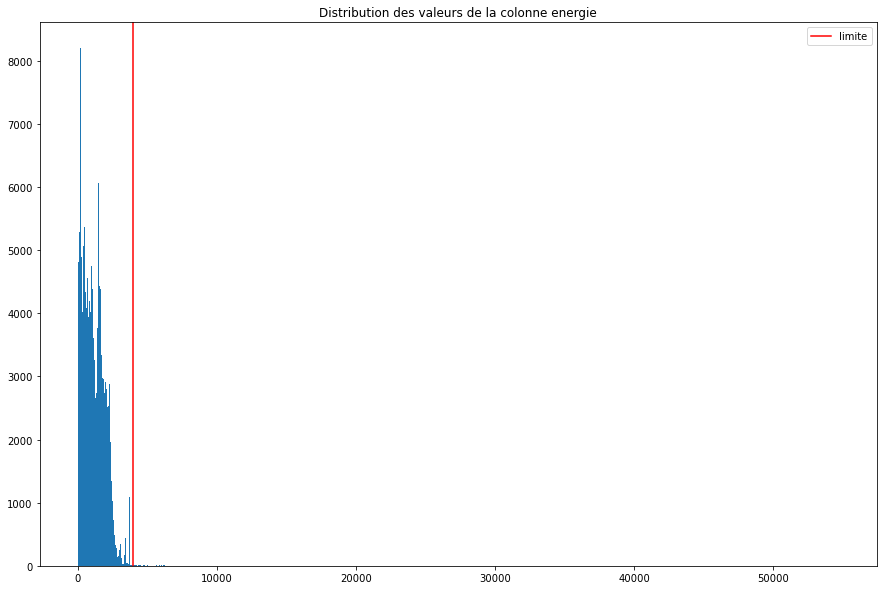

In [66]:
plt.figure(figsize=(15,10))
plt.title("Distribution des valeurs de la colonne energie")
_ = plt.hist(dffr6['energy_100g'],bins=1000)
plt.axvline(4000,color='red',label='limite')
plt.legend()

In [67]:
dffr6.loc[dffr6['energy_100g'] > 4000, 'energy_100g'] = 4000
print("Une limite semble se profiler aux alentours de la valeur 4000")

Une limite semble se profiler aux alentours de la valeur 4000


* globalement, il n'y a pas de valeurs aberrantes et même si certaines valeurs s'écartent du domaine de définition les erreurs ne sont pas trés grandes à l'exception des colonnes <code>salt</code> et <code>sodium</code>, pour lesquelles nous allons ramener manuellement les valeurs aberrantes au la borne supérieur du domaine de définition prévu par la nomenclature.

# Export des données

In [68]:
print("Le jeu de données que nous allons donc exploiter contient finalement {} colonnes et {} lignes.".format(len(quant_cats),dffr6.shape[0]))

Le jeu de données que nous allons donc exploiter contient finalement 9 colonnes et 181777 lignes.


In [69]:
dffr6[quant_cats].to_csv("mydf.csv",encoding='utf8',sep='\t',index=False)